## 0. Import libraries 

In [1]:
# Standard Python libraries
import os
from pathlib import Path

# External packages
from garmin_fit_sdk import Decoder, Stream
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

## 1. Define functions

### a. Define function to convert semicircle into decimal degrees (WGS 84)
Garmin saves its coordinates as semicircles, which reduces storage capacity, but it means that we have to convert it into a more useful geometry before we can use it.

In [2]:
def convert_semicircle_to_degrees(semicircle_value):
    return semicircle_value * (180 / 2**31)

## 2. Define filepaths
1. `activity_directory` is the directory in which the FIT files are located
2. `activity_file` is the individual FIT file you want to work with

In [3]:
activity_directory = r"HealthData\FitFiles\Activities"
activity_file = "4380310007_ACTIVITY.fit"

In [4]:
# generate the full filepath to the requested file
home = Path.home()
activity_filepath = os.path.join(home, activity_directory, activity_file)

In [5]:
stream = Stream.from_file(activity_filepath)
decoder = Decoder(stream)
messages, errors = decoder.read()

In [16]:
coordinates = []        # save each coordinate as a tuple in this list

indices = list(range(len(messages['record_mesgs'])))        # create a list [0, 1, 2, ... , len(coordinates)]

# add each coordinate to the coordinates list
for msg in messages['record_mesgs']:
    lat = convert_semicircle_to_degrees(msg['position_lat'])
    long = convert_semicircle_to_degrees(msg['position_long'])
    coordinates.append(Point(long, lat))

df_data = {'Point_Num': indices, 'geometry': coordinates}       # this dictionary will be turned into a GeoDataFrame

In [17]:
sample_df = gpd.GeoDataFrame(df_data, crs="EPSG:4326")       # use WGS 84

print(sample_df.head())

   Point_Num                    geometry
0          0  POINT (-93.48975 45.03236)
1          1  POINT (-93.48977 45.03235)
2          2  POINT (-93.48977 45.03233)
3          3  POINT (-93.48978 45.03227)
4          4  POINT (-93.48978 45.03223)


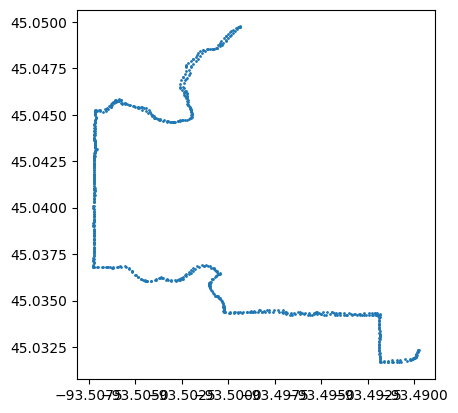

EPSG:4326


In [18]:
# plot the points
sample_df.plot(aspect=1, markersize=1)
plt.show()
print(sample_df.crs)

In [ ]:
'''
speed measured in m/s
distance measured in m

'record_mesgs' contains coordinates, etc.

{'timestamp': datetime.datetime(2019, 12, 29, 21, 26, 50, tzinfo=datetime.timezone.utc),
'position_lat': 537257002, 'position_long': -1115376201, 'distance': 0.0, 'altitude': 322.20000000000005,
'speed': 1.185, 'cycle_length16': 0.5, 88: 100, 'heart_rate': 86, 'cadence': 55, 'temperature': 26,
'fractional_cadence': 0.5, 'enhanced_speed': 1.185, 'enhanced_altitude': 322.20000000000005}
'''